In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Load the pre-trained model without the top layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new top layer for classification
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(21, activation='softmax')(x)

# Create the new model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

17225924/17225924 [==============================] - 0s 0us/step


In [3]:
# Set up the data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/kaggle/input/landuse-scene-classification/images_train_test_val/train', target_size=(224, 224), batch_size=32, class_mode='categorical',shuffle=False)
val_generator = test_datagen.flow_from_directory('/kaggle/input/landuse-scene-classification/images_train_test_val/validation', target_size=(224, 224), batch_size=32, class_mode='categorical',shuffle=False)

# Train the model
ret_model=model.fit(train_generator, epochs=10, validation_data=val_generator)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Epoch 1/10
230/230 [==============================] - 163s 674ms/step - loss: 2.0840 - accuracy: 0.4586 - val_loss: 0.9629 - val_accuracy: 0.6814
Epoch 2/10
230/230 [==============================] - 111s 481ms/step - loss: 0.7035 - accuracy: 0.7611 - val_loss: 0.5044 - val_accuracy: 0.8414
Epoch 3/10
230/230 [==============================] - 109s 474ms/step - loss: 0.3910 - accuracy: 0.8672 - val_loss: 0.4420 - val_accuracy: 0.8514
Epoch 4/10
230/230 [==============================] - 110s 478ms/step - loss: 0.2951 - accuracy: 0.8967 - val_loss: 0.2896 - val_accuracy: 0.9019
Epoch 5/10
230/230 [==============================] - 113s 492ms/step - loss: 0.2445 - accuracy: 0.9174 - val_loss: 0.2732 - val_accuracy: 0.9076
Epoch 6/10
230/230 [==============================] - 110s 479ms/step - loss: 0.2292 - accuracy: 0.9205 - val_loss: 0.2134 - val_accuracy: 0.9324
Epoch 7/10
230/230 [==================

In [4]:
from sklearn.metrics import confusion_matrix , classification_report 
import seaborn as sns

In [5]:
test_dataset = '/kaggle/input/landuse-scene-classification/images_train_test_val/test'
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=32,
                                                 target_size = (256,256),
                                                 class_mode='categorical')

Found 1050 images belonging to 21 classes.


In [6]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

33/33 [==============================] - 11s 329ms/step - loss: 0.1918 - accuracy: 0.9276


In [7]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.19181299209594727
Test Accuracy: 0.9276190400123596


In [8]:
class_label=list(train_generator.class_indices.keys())

In [9]:
import numpy as np
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

33/33 [==============================] - 5s 140ms/step


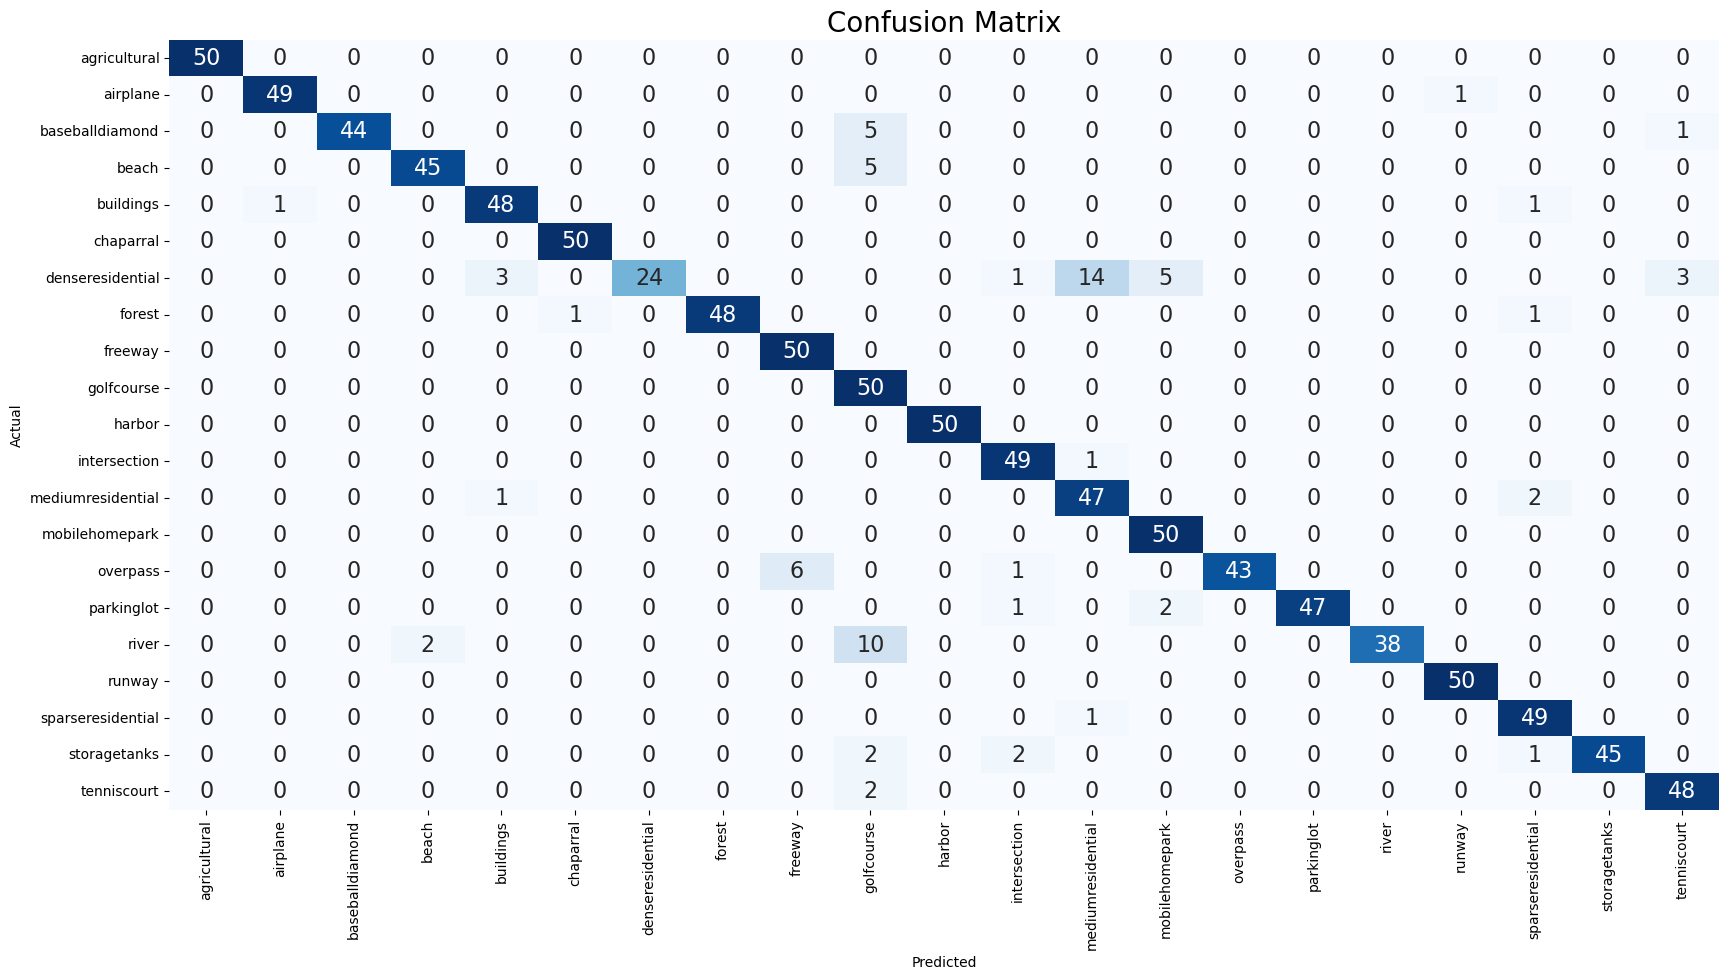

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=class_label, index = class_label)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [11]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.98      0.98        50
           2       1.00      0.88      0.94        50
           3       0.96      0.90      0.93        50
           4       0.92      0.96      0.94        50
           5       0.98      1.00      0.99        50
           6       1.00      0.48      0.65        50
           7       1.00      0.96      0.98        50
           8       0.89      1.00      0.94        50
           9       0.68      1.00      0.81        50
          10       1.00      1.00      1.00        50
          11       0.91      0.98      0.94        50
          12       0.75      0.94      0.83        50
          13       0.88      1.00      0.93        50
          14       1.00      0.86      0.92        50
          15       1.00      0.94      0.97        50
          16       1.00      0.76      0.86        50
          17       0.98    

/tmp/ipykernel_23/1325861010.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc,'b', color="orange", label='Validation error')


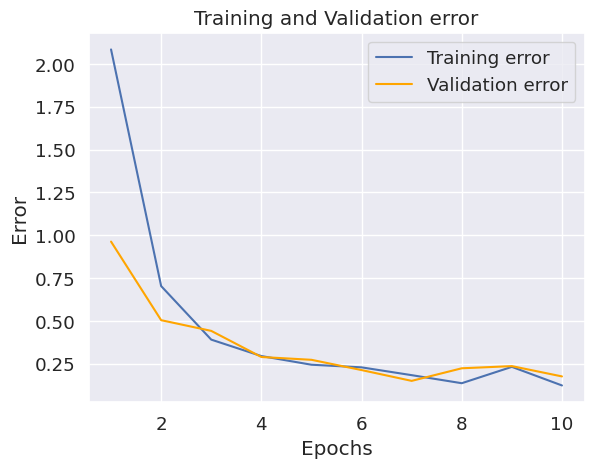

In [12]:
history_dict = ret_model.history
train_acc = history_dict['loss']
val_acc = history_dict['val_loss']
epochs = range(1, len(history_dict['loss'])+1)
plt.plot(epochs, train_acc,'b', label='Training error')
plt.plot(epochs, val_acc,'b', color="orange", label='Validation error')
plt.title('Training and Validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

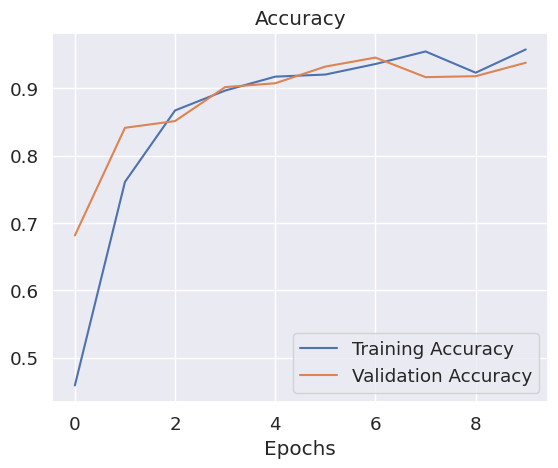

In [13]:
loss = ret_model.history['loss']
val_loss = ret_model.history['val_loss']  
accuracy = ret_model.history['accuracy']
val_accuracy = ret_model.history['val_accuracy']
epochs = range(len(ret_model.history['loss']))
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();